In [1]:
from nilearn import datasets, plotting, image
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "1"

/home/ogrisel/.virtualenvs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# By default 2nd subject will be fetched
data = datasets.fetch_haxby(subjects=(2,))
# 'func' is a list of filenames: one for each subject
fmri_filename = data.func[0]

# print basic information on the dataset
print('First subject functional nifti images (4D) are at: %s' %
      fmri_filename)  # 4D data

First subject functional nifti images (4D) are at: /home/ogrisel/nilearn_data/haxby2001/subj2/bold.nii.gz


/home/ogrisel/.virtualenvs/py36/lib/python3.6/site-packages/nilearn/image/image.py:192: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Converting to None (no smoothing option)
  .format(fwhm))


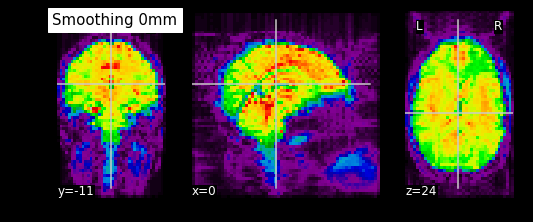

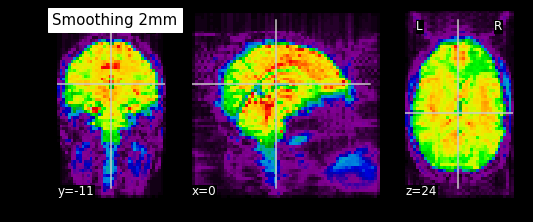

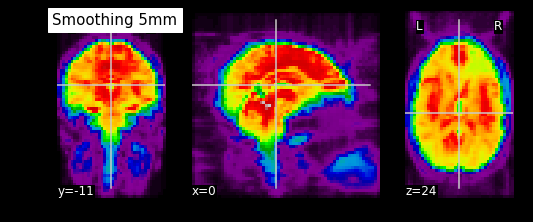

In [3]:
first_epi_file = data.func[0]

# First the compute the mean image, from the 4D series of image
mean_func = image.mean_img(first_epi_file)

# Then we smooth, with a varying amount of smoothing, from none to 20mm
# by increments of 5mm
for smoothing in [0, 2, 5] :
    smoothed_img = image.smooth_img(mean_func, smoothing)
    plotting.plot_epi(smoothed_img, title="Smoothing %imm" % smoothing)

In [4]:
smoothed_img = image.smooth_img(fmri_filename, 2)

In [5]:
smoothed_img.shape

(40, 64, 64, 1452)

In [6]:
smoothed_img.shape

(40, 64, 64, 1452)

In [37]:
smoothed_data = smoothed_img.get_data().transpose(3, 0, 1, 2)
# mean = smoothed_data.mean(axis=0)
# smoothed_data -= mean
# scale = smoothed_data.std(axis=0) + 1e-6
# smoothed_data /= scale
scale = smoothed_data.std()  # global scale
smoothed_data /= scale

In [38]:
smoothed_data = smoothed_data[:, :, :, :, None]
smoothed_data.shape

(1452, 40, 64, 64, 1)

In [39]:
smoothed_data_train = smoothed_data[:1200]
smoothed_data_test = smoothed_data[1200:]

In [40]:
smoothed_data_train.nbytes / 1e6

786.432

In [41]:
input_shape = smoothed_data_train.shape[1:]

In [129]:
from keras.models import load_model


autoencoder = load_model('haxby_autoencoder_best.hdf5')

In [130]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_20 (Sequential)   (None, 256)               2283200   
_________________________________________________________________
sequential_21 (Sequential)   (None, 40, 64, 64, 1)     2029201   
Total params: 4,312,401
Trainable params: 4,310,257
Non-trainable params: 2,144
_________________________________________________________________
None


In [131]:
encoder = autoencoder.layers[0]
decoder = autoencoder.layers[1]

In [132]:
print(encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 40, 64, 64, 16)    448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 64, 64, 16)    64        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 20, 32, 32, 32)    13856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 32, 32, 32)    128       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 20, 32, 32, 32)    27680     
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 32, 32, 32)    128       
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 10, 16, 16, 64)    55360     
__________

In [133]:
%%time
encoded_train = encoder.predict(smoothed_data_train,
                                batch_size=32)

CPU times: user 3.71 s, sys: 80 ms, total: 3.79 s
Wall time: 6.96 s


In [134]:
encoded_train.shape

(1200, 256)

In [135]:
encoded_train.nbytes / 1e6

1.2288

In [136]:
print(decoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 2, 128)      0         
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 4, 4, 4, 128)      442496    
_________________________________________________________________
batch_normalization_8 (Batch (None, 4, 4, 4, 128)      512       
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 4, 4, 4, 128)      442496    
_________________________________________________________________
batch_normalization_9 (Batch (None, 4, 4, 4, 128)      512       
__________

In [137]:
%%time
reconstructed_train = autoencoder.predict(smoothed_data_train)
reconstructed_test = autoencoder.predict(smoothed_data_test)

CPU times: user 9.21 s, sys: 2.17 s, total: 11.4 s
Wall time: 15 s


In [138]:
%%time
encoded_train = encoder.predict(smoothed_data_train)
encoded_test = encoder.predict(smoothed_data_test)

CPU times: user 2.17 s, sys: 100 ms, total: 2.27 s
Wall time: 6.13 s


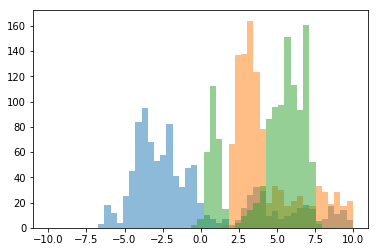

In [139]:
for i in [0, 50, 100]:
    plt.hist(encoded_train[:, i], bins=np.linspace(-10, 10, 50),
             alpha=0.5);

In [140]:
reconstructed_test.shape

(252, 40, 64, 64, 1)

In [141]:
reconstructed_test.nbytes / 1e6 

165.15072

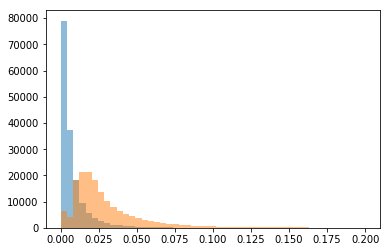

In [157]:
bins = np.linspace(0, 0.2, 50)
plt.hist(reconstructed_test.std(axis=0).ravel(), bins=bins, alpha=0.5);
plt.hist(smoothed_data_test.std(axis=0).ravel(), bins=bins, alpha=0.5);

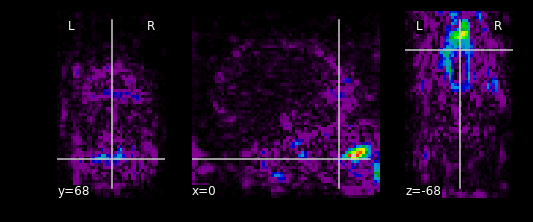

In [158]:
reconstructed_test_img = Nifti1Image(
    reconstructed_test.std(axis=0)[:, :, :, 0],
    smoothed_img.affine)
plotting.plot_epi(reconstructed_test_img);

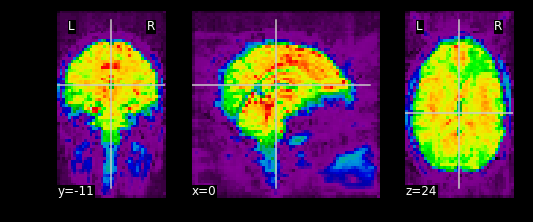

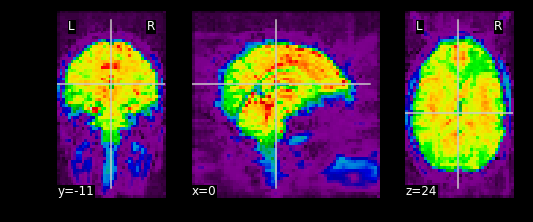

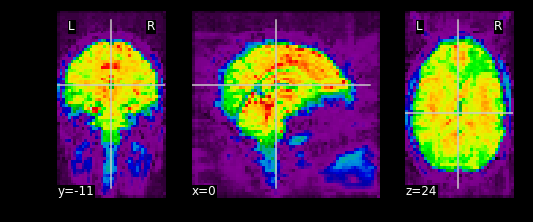

In [142]:
from nibabel import Nifti1Image

for img_idx in [0, 50, 100]:
    reconstructed_test_img = Nifti1Image(
        reconstructed_test[:, :, :, :, 0].transpose(1, 2, 3, 0)[:, :, :, img_idx],
        smoothed_img.affine)
    plotting.plot_epi(reconstructed_test_img);

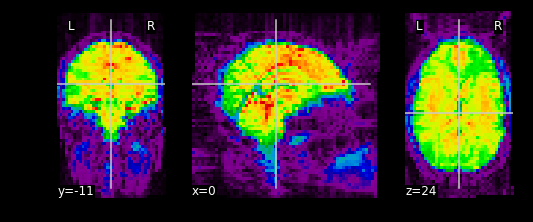

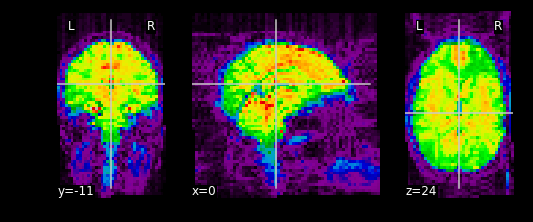

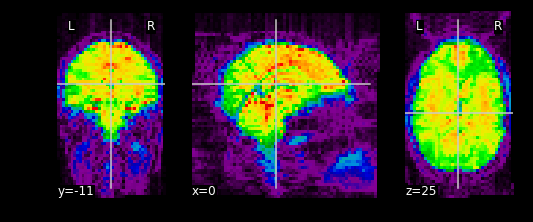

In [143]:
for img_idx in [0, 50, 100]:
    test_img = Nifti1Image(
        smoothed_data_test[:, :, :, :, 0].transpose(1, 2, 3, 0)[:, :, :, img_idx],
        smoothed_img.affine)
    plotting.plot_epi(test_img);

In [146]:
import pandas as pd

# Load behavioral information
behavioral = pd.read_csv(data.session_target[0], sep=" ")
print(behavioral)

        labels  chunks
0         rest       0
1         rest       0
2         rest       0
3         rest       0
4         rest       0
5         rest       0
6     scissors       0
7     scissors       0
8     scissors       0
9     scissors       0
10    scissors       0
11    scissors       0
12    scissors       0
13    scissors       0
14    scissors       0
15        rest       0
16        rest       0
17        rest       0
18        rest       0
19        rest       0
20        rest       0
21        face       0
22        face       0
23        face       0
24        face       0
25        face       0
26        face       0
27        face       0
28        face       0
29        face       0
...        ...     ...
1422      rest      11
1423       cat      11
1424       cat      11
1425       cat      11
1426       cat      11
1427       cat      11
1428       cat      11
1429       cat      11
1430       cat      11
1431       cat      11
1432      rest      11
1433      r

In [148]:
condition_mask = behavioral['labels'].isin(['face', 'cat'])
condition_mask

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
        ...  
1422    False
1423     True
1424     True
1425     True
1426     True
1427     True
1428     True
1429     True
1430     True
1431     True
1432    False
1433    False
1434    False
1435    False
1436    False
1437    False
1438    False
1439    False
1440    False
1441    False
1442    False
1443    False
1444    False
1445    False
1446    False
1447    False
1448    False
1449    False
1450    False
1451    False
Name: labels, Length: 1452, dtype: bool